### Loading datasets

In [1]:
import torch
import cv2
import torchvision.transforms.functional as F
import numpy as np
import matplotlib.pyplot as plt

from optical_flow.spynet import spynet_optical_flow 
from optical_flow.farneback import farneback_optical_flow
from data.dataset import MultiDataset

# Dataset and Loader
dataset_test = MultiDataset(
    ['data/same_vis_same_phys/train/sample_0/',
     'data/same_vis_same_phys/train/sample_1/',
     'data/same_vis_same_phys/train/sample_2/',
     'data/same_vis_same_phys/train/sample_3/'],
    img_size=(256, 256),
    buffer_size=3,
    random_order=True
    )

loader_train = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=4,  # we have modified data_parallel
    shuffle=False,  # we do not use this param
    drop_last=True,
    pin_memory=True)

# create loader iterator
iterator_train = iter(loader_train)

In [2]:
plt.rcParams["savefig.bbox"] = 'tight'

def img_de_transform(img):
    # 0-1 to 1-255
    img = np.float32(np.array(img)) * 255.
    img = img.transpose((1, 2, 0))
    img = torch.from_numpy(img.copy())
    return img

def show(imgs):
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [3]:
output = iterator_train.next()

In [11]:
opt_flow_1 = spynet_optical_flow(output['img_data'][0][0], output['img_data'][0][1]).detach().numpy()
opt_flow_2 = farneback_optical_flow(output['img_data'][0][0], output['img_data'][0][1]).detach().numpy()


objOutput = open('out.flo', 'wb')
np.array([ 80, 73, 69, 72 ], np.uint8).tofile(objOutput)
np.array([ opt_flow_1.shape[2], opt_flow_1.shape[1] ], np.int32).tofile(objOutput)
np.array(opt_flow_1.transpose(1, 2, 0), np.float32).tofile(objOutput)
objOutput.close()

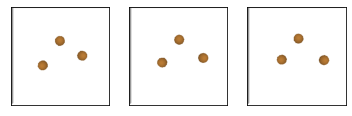

In [52]:
show(output['img_data'][0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


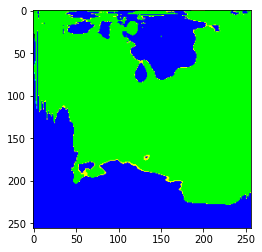

In [9]:
hsv = np.zeros((256,256, 3), dtype=np.float32)
hsv[..., 1] = 255
mag, ang = cv2.cartToPolar(opt_flow_1[0, ...], opt_flow_1[1, ...])
#mag, ang = cv2.cartToPolar(opt_flow[..., 0], opt_flow[..., 1])
hsv[..., 0] = ang*180/np.pi/2
hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
plt.imshow(bgr)